In [1]:
%matplotlib inline


# Simple 1D Kernel Density Estimation

This example uses the :class:`sklearn.neighbors.KernelDensity` class to
demonstrate the principles of Kernel Density Estimation in one dimension.

The first plot shows one of the problems with using histograms to visualize
the density of points in 1D. Intuitively, a histogram can be thought of as a
scheme in which a unit "block" is stacked above each point on a regular grid.
As the top two panels show, however, the choice of gridding for these blocks
can lead to wildly divergent ideas about the underlying shape of the density
distribution.  If we instead center each block on the point it represents, we
get the estimate shown in the bottom left panel.  This is a kernel density
estimation with a "top hat" kernel.  This idea can be generalized to other
kernel shapes: the bottom-right panel of the first figure shows a Gaussian
kernel density estimate over the same distribution.

Scikit-learn implements efficient kernel density estimation using either
a Ball Tree or KD Tree structure, through the
:class:`sklearn.neighbors.KernelDensity` estimator.  The available kernels
are shown in the second figure of this example.

The third figure compares kernel density estimates for a distribution of 100
samples in 1 dimension.  Though this example uses 1D distributions, kernel
density estimation is easily and efficiently extensible to higher dimensions
as well.



https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/ choose bandwidth thru cross validation.
However, bandwidth can be determind by Silverman's rule

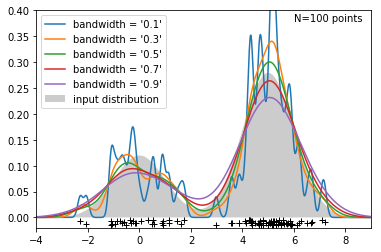

In [2]:

# Author: Jake Vanderplas <jakevdp@cs.washington.edu> 
## commented: Jun Yuan <jy448@njit.edu>


#### import the packages #######
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}
###############################





### simulate 100 data point#####
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
################################





## making the model
#############################################
 
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis] # make the grid array 

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0]) ## X_plot[:, 0] is just convert the array into 1D array
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0])) ## only to make the gray area for comparision. Unknown in real work

fig, ax = plt.subplots() ## get the axis object
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution') ## make the gray area



#######get kernel density and make the line ### 

for bandwidth in [0.1,0.3,0.5,0.7,0.9]: ### however, bandwidth can be determind by Silverman's rule
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X) ## fit the data point, output a kernel density function
                                                           ## try change the bandwidth, it control the smoothness
    log_dens = kde.score_samples(X_plot)  ## sample the kernel density function for the grid, ouput log(density)s
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="bandwidth = '{0}'".format(bandwidth)) ## tansfer to the real density values, then print (x grid, dens)

###############################################


######## decorating the plot ##################
ax.text(6, 0.38, "N={0} points".format(N)) # print "N = 100 points" on the upper right corner

ax.legend(loc='upper left') ## print legend information upper left corner 

ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k') ## print the  data point as "+"s in the bottom
ax.set_xlim(-4, 9)  ## limits for x axis
ax.set_ylim(-0.02, 0.4)  ##limits for y axis

plt.show() ## show the final plot

# Fast Sampling 

https://medium.freecodecamp.org/how-to-get-embarrassingly-fast-random-subset-sampling-with-python-da9b27d494d9

The author proved that the fast sampling actually reduce the chance of getting the same sample (sample Collision)

In [4]:
%load_ext Cython

In [5]:
%%cython 
import numpy as np
cimport numpy as np
cimport cython # so we can use cython decorators
from cpython cimport bool # type annotation for boolean

# disable index bounds checking and negative indexing for speedups
@cython.wraparound(False)
@cython.boundscheck(False)
cdef cython_get_sample(np.ndarray arr, arr_len, n_iter, int sample_size, 
               bool fast):
    cdef int start_idx
    if fast:
        start_idx = (n_iter * sample_size) % arr_len
        if start_idx + sample_size >= arr_len:
            np.random.shuffle(arr)
            
        return arr[start_idx:start_idx+sample_size] 
    else:
        return np.random.choice(arr, sample_size, replace=False)

@cython.wraparound(False)
@cython.boundscheck(False)
def cython_collect_samples(np.ndarray arr,
                    int sample_size,
                    int n_samples,
                    bool fast=False):
    
    cdef np.ndarray samples
    cdef int arr_len
    cdef int sample_len
    cdef np.ndarray sample
    samples = np.zeros((n_samples + 1, sample_size), np.int64)
    arr_len = len(arr)
    
    for sample_n in range(0, n_samples):
        sample = cython_get_sample(arr, arr_len, sample_n,
                            sample_size,
                            fast)
        samples[sample_n] = sample
        
    return samples

In [6]:
n = 10000000 ## number of the total records

arr = np.array([i for i in range(n)]) 
samples= cython_collect_samples(arr,1000,403,fast=True) ## get 403 samples from 1000000 records for 1000 times
samples

array([[     0,      1,      2, ...,    997,    998,    999],
       [  1000,   1001,   1002, ...,   1997,   1998,   1999],
       [  2000,   2001,   2002, ...,   2997,   2998,   2999],
       ...,
       [401000, 401001, 401002, ..., 401997, 401998, 401999],
       [402000, 402001, 402002, ..., 402997, 402998, 402999],
       [     0,      0,      0, ...,      0,      0,      0]])

In [7]:
n = 10000000 ## number of the total records

arr = np.array([i for i in range(n)]) 
samples= cython_collect_samples(arr,1000,403,fast=False) #using the python default sampling method 
samples

array([[3750126,  636522, 2673366, ..., 9431998, 1968804, 1859326],
       [ 815870, 4344047, 8498928, ..., 7134596, 1075516, 5315733],
       [5886174,  452852, 5675322, ..., 1523578, 5004862, 5644046],
       ...,
       [7299901,  463018, 5086096, ..., 3691126, 6367666, 4475873],
       [9268467, 7714229, 1137324, ..., 2778929, 2025285, 2925210],
       [      0,       0,       0, ...,       0,       0,       0]])

### Make a matrix D, row and column is the array of all the companies (0,1,2,3,4,.....), Dij value in the matrix is the distance between company i and j.

In [34]:
arr1 = [3,1,4,2,6,5]
arr1


[3, 1, 4, 2, 6, 5]

In [35]:
for j in range(5):
    for i in range(j+1,6):
        print(arr1[j], arr1[i])

3 1
3 4
3 2
3 6
3 5
1 4
1 2
1 6
1 5
4 2
4 6
4 5
2 6
2 5
6 5


### get the values of (arr1[j],arr[i]) in the distance matrix to be the data points and feed to the model discussed at the top of the page.

### First, get the density estimation functions for the specific industry and all the 10000 iterations. then we can think about plotting the confidence interval or else. 